# PCA + k-Means on ERA5 Data

## Results

- Data loading takes ~5min
- Data preprocessing takes ~4min
- PCA with 500 PCs takes ~8min
- PCA (reduced PCs), Transforming and clustering (2 x k-Means) takes ~2min
- kPCA with 500 PCs takes ~2min
- kPCA (reduced PCs), Transforming and clustering (2 x k-Means) takes ~3min
- PCA:
  - N_pcs=24 cover 0.7 of the variance
  - N_pcs=80 cover 0.8 of the variance
  - N_pcs=171 cover 0.85 of the variance
  - N_pcs=421 cover 0.9 of the variance
- kPCA:
  - N_pcs=1 cover 0.4 of the variance
  - N_pcs=2 cover 0.5 of the variance
  - N_pcs=3 cover 0.6000000000000001 of the variance
  - N_pcs=6 cover 0.7000000000000001 of the variance
  - N_pcs=15 cover 0.8 of the variance
  - N_pcs=54 cover 0.9 of the variance

In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import pathlib
import joblib

import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
import pandas as pd

import a6
import a6.plotting._colors as _colors

path = pathlib.Path(
    "/p/project/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12.nc"
)
plots = pathlib.Path("/p/project/deepacf/emmerich1/plots")

In [3]:
%%time

ds = xr.open_dataset(path)

coordinates = a6.datasets.coordinates.Coordinates()
variables = a6.datasets.variables.Model()

ds

CPU times: user 456 ms, sys: 563 ms, total: 1.02 s
Wall time: 1.21 s


<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 141, level: 5, time: 21826)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * level      (level) int32 300 500 700 850 950
  * time       (time) datetime64[ns] 1964-01-01T12:00:00 ... 2023-10-03T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 17:05:15 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [2]:
%%time

masked = a6.datasets.methods.mask.set_nans_to_mean(ds, coordinates=coordinates)
data = (
    (
        a6.features.methods.weighting.weight_by_latitudes(
            latitudes=coordinates.latitude,
            use_sqrt=True,
        )
        >> a6.features.methods.reshape.xarray.reshape_spatio_temporal_data(
            # Set to None to avoid memory excess in function
            time_coordinate=None,
        )
        >> a6.features.methods.standardization.normalize_features()
    )
    .apply_to(masked)
    .compute()
)
del ds
del masked

NameError: name 'ds' is not defined

In [4]:
%%time

# data.to_netcdf("/p/project/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12_preprocssed_for_pca.nc")
# del data

data = (
    xr.open_dataset(
        "/p/project/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12_preprocssed_for_pca.nc"
    )
    .to_dataarray()
    .values[0]
)

CPU times: user 1.68 s, sys: 5.11 s, total: 6.79 s
Wall time: 10.4 s


In [20]:
%%time

pca = sklearn.decomposition.PCA(n_components=80).fit(data)
joblib.dump(pca, "/p/project/deepacf/emmerich1/data/pca_500_pcs.joblib")

# pca = joblib.load("/p/project/deepacf/emmerich1/data/pca_500_pcs.joblib")
cum_evr = np.cumsum(pca.explained_variance_ratio_)

CPU times: user 9min 43s, sys: 2min 5s, total: 11min 49s
Wall time: 44.1 s


In [25]:
import scipy.sparse
import sklearn.utils.sparsefuncs

def transform(pca, X, n_components: int):
    X = pca._validate_data(
        X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32], reset=False
    )
    if pca.mean_ is not None:
        if scipy.sparse.issparse(X):
            X = sklearn.utils.sparsefuncs._implicit_column_offset(X, pca.mean_)
        else:
            X = X - pca.mean_
    X_transformed = X @ pca.components_[:n_components, :].T
    if pca.whiten:
        X_transformed /= xp.sqrt(pca.explained_variance_[:n_components])
    return X_transformed

In [26]:
for n_pcs in range(1, 3):
    print(f"n_pcs={n_pcs}", end="\r")
    transformed = transform(pca=pca, X=data, n_components=n_pcs)
    transformed = sklearn.preprocessing.StandardScaler().fit_transform(transformed)
    for k in range(1, 3):
        print(f"k={k}", end="\r")
        kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(transformed)

: 

: 

In [6]:
%%time

for n_pcs in range(1, 3):
    print("n_pcs=")
    print(f"n_pcs={n_pcs}", end="\r")
    # transformed = sklearn.decomposition.PCA(n_components=n_pcs).fit_transform(data)
    transformed = sklearn.decomposition.KernelPCA(
        n_components=n_pcs,
        copy_X=False,
    ).fit_transform(data)
    transformed = sklearn.preprocessing.StandardScaler().fit_transform(transformed)
    for k in range(1, 3):
        print("k=")
        print(f"k={k}", end="\r")
        kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(transformed)

n_pcs=
k=pcs=1
k=1
k=2


: 

: 

In [ ]:
%%time

plt.plot(list(range(pca.n_components_)), cum_evr)
for var in np.arange(0, 1.0, 0.1):
    n_pcs = np.where(cum_evr > var)[0][0]
    print(f"N_pcs={n_pcs} cover {var} of the variance")
n_pcs = np.where(cum_evr > 0.80)[0][0]
transformed = sklearn.decomposition.PCA(n_components=n_pcs).fit_transform(data)
transformed_standardized = sklearn.preprocessing.StandardScaler().fit_transform(transformed)
kmeans_pca_40 = sklearn.cluster.KMeans(n_clusters=40).fit(transformed_standardized)
kmeans_pca_30 = sklearn.cluster.KMeans(n_clusters=30).fit(transformed_standardized)

kmeans_pca_40_labels = kmeans_pca_40.labels_
kmeans_pca_30_labels = kmeans_pca_30.labels_

In [ ]:
%%time
joblib.dump(
    kmeans_pca_40, "/p/project/deepacf/emmerich1/data/kmeans_pca_40.joblib"
)
joblib.dump(
    kmeans_pca_30, "/p/project/deepacf/emmerich1/data/kmeans_pca_30.joblib"
)

del pca
del transformed
del kmeans_pca_40
del kmeans_pca_30

Kernel PCA: Gaussian radial basis function with $\sigma = 200$ (see http://dx.doi.org/10.1016/j.procs.2011.08.043)

In [ ]:
%%time

kpca = sklearn.decomposition.KernelPCA(
    n_components=500,
    copy_X=False,
).fit(data)

In [ ]:
%%time
cum_evr = np.cumsum(kpca.eigenvalues_ / np.sum(kpca.eigenvalues_))
plt.plot(list(range(len(kpca.eigenvalues_))), cum_evr)
for var in np.arange(0, 1.0, 0.1):
    n_pcs = np.where(cum_evr > var)[0][0]
    print(f"N_pcs={n_pcs} cover {var} of the variance")
n_pcs = np.where(cum_evr > 0.80)[0][0]
transformed = sklearn.decomposition.KernelPCA(
    n_components=n_pcs, copy_X=False
).fit_transform(data)
kmeans_kpca_40 = sklearn.cluster.KMeans(n_clusters=40).fit(transformed)
kmeans_kpca_30 = sklearn.cluster.KMeans(n_clusters=30).fit(transformed)

kmeans_kpca_40_labels = kmeans_pca_40.labels_
kmeans_kpca_30_labels = kmeans_pca_30.labels_

In [ ]:
%%time

joblib.dump(kpca, "/p/project/deepacf/emmerich1/data/kpca_500_pcs.joblib")
joblib.dump(
    kmeans_kpca_40, "/p/project/deepacf/emmerich1/data/kmeans_kpca_40.joblib"
)
joblib.dump(
    kmeans_kpca_30, "/p/project/deepacf/emmerich1/data/kmeans_kpca_30.joblib"
)

del kpca
del transformed
del kmeans_kpca_40
del kmeans_kpca_30

In [ ]:
%%time

ds = xr.open_dataset(path)

# Add +1 to be conform to the GWL labels
kmeans_pca_40 = joblib.load(
    "/p/project/deepacf/emmerich1/data/kmeans_pca_40.joblib"
)
kmeans_pca_30 = joblib.load(
    "/p/project/deepacf/emmerich1/data/kmeans_pca_30.joblib"
)
kmeans_pca_40_labels = kmeans_pca_40.labels_ + 1
kmeans_pca_30_labels = kmeans_pca_30.labels_ + 1

kmeans_kpca_40 = joblib.load(
    "/p/project/deepacf/emmerich1/data/kmeans_kpca_40.joblib"
)
kmeans_kpca_30 = joblib.load(
    "/p/project/deepacf/emmerich1/data/kmeans_kpca_30.joblib"
)
kmeans_kpca_40_labels = kmeans_kpca_40.labels_ + 1
kmeans_kpca_30_labels = kmeans_kpca_30.labels_ + 1

# Need to convert dates to YYYY-MM-DD to be conform with GWL dataset time stamps.
times = a6.utils.times.time_steps_as_dates(ds, coordinates=coordinates)

results = xr.Dataset(
    data_vars={
        "PCA": (
            ["time", "k"],
            list(zip(kmeans_pca_30_labels, kmeans_pca_40_labels)),
        ),
        "kPCA": (
            ["time", "k"],
            list(zip(kmeans_kpca_30_labels, kmeans_kpca_40_labels)),
        ),
    },
    coords={
        "time": times,
        "k": [30, 40],
    },
    attrs={
        "description": "Resulting LSWR labels from K-Means clustering on PCA and kernel PCA of the ERA5 data (1964-2023)",
    },
)
results.to_netcdf(
    "/p/project/deepacf/emmerich1/data/pca_kpca_kmeans_lswrs_30_40.nc"
)
results

## Plotting

In [25]:
results = xr.open_dataset(
    "/p/project/deepacf/emmerich1/data/pca_kpca_kmeans_lswrs_30_40.nc"
)

n_lswr_categories = 40
results_40 = results.sel(k=n_lswr_categories)
gwl = xr.open_dataset(
    "/p/home/jusers/emmerich1/juwels/code/a6/src/tests/data/gwl.nc"
)

# NOTE: Uncomment to save dcv2 to disk, or read from disk
# dcv2 = torch.load(
#     "/p/scratch/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023/results/tensors/epoch-799-assignments.pt",
#     map_location=torch.device("cpu"),
# )
# dcv2 = xr.DataArray(
#     # Need to add +1 to be conform with GWL labels
#     dcv2.numpy()[0] + 1,
#     name="DCv2",
#     coords={"time": results["time"]},
#     dims=["time"],
# )
# dcv2.to_netcdf("/p/project/deepacf/emmerich1/data/dcv2-lswrs.nc")

dcv2 = xr.open_dataset("/p/project/deepacf/emmerich1/data/dcv2-lswrs.nc")["DCv2"]

lswrs = [gwl["GWL"], results_40["PCA"], results_40["kPCA"], dcv2]

In [26]:
import matplotlib.pyplot as plt

pca = joblib.load("/p/project/deepacf/emmerich1/data/pca_500_pcs.joblib")
kpca = joblib.load("/p/project/deepacf/emmerich1/data/kpca_500_pcs.joblib")

pca_cum_evr = np.cumsum(pca.explained_variance_ratio_)
kpca_evr = kpca.eigenvalues_ / np.sum(kpca.eigenvalues_)
kpca_cum_evr = np.cumsum(kpca_evr)

## Explained Variance Ratio Plots

RANK None (LOCAL None) - DEBUG - 2024-05-08 16:36:31 - 1:27:59 - vmin 0.91 vmax 682.2106651607091
RANK None (LOCAL None) - DEBUG - 2024-05-08 16:36:31 - 1:27:59 - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
RANK None (LOCAL None) - DEBUG - 2024-05-08 16:36:31 - 1:27:59 - vmin 0.91 vmax 682.2106651607091
RANK None (LOCAL None) - DEBUG - 2024-05-08 16:36:31 - 1:27:59 - ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
                                                                        2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
                                                                        2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
                                                                        2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
                                                                        2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7

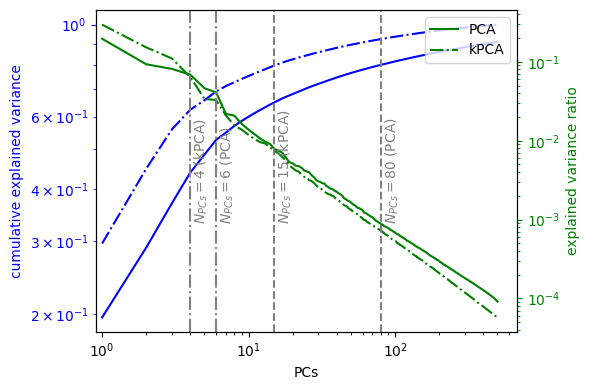

In [29]:
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.set_xlabel("PCs")

x = list(range(1, pca.n_components + 1))

# Plot cumulative variance on first axis
ax1_color = "blue"
ax1.set_ylabel("cumulative explained variance", color=ax1_color)
ax1.plot(x, pca_cum_evr, color=ax1_color, linestyle="-", label="PCA")
ax1.plot(x, kpca_cum_evr, color=ax1_color, linestyle="-.", label="kPCA")

# Create right axis.
ax2 = ax1.twinx()

# Plot the explained variance ratios.
ax2_color = "green"
ax2.set_ylabel("explained variance ratio", color=ax2_color)
ax2.plot(
    x,
    pca.explained_variance_ratio_,
    color=ax2_color,
    linestyle="-",
    label="PCA",
)
ax2.plot(x, kpca_evr, color=ax2_color, linestyle="-.", label="kPCA")

for ax, color in [(ax1, ax1_color), (ax2, ax2_color)]:
    # Set log scale.
    ax.set(xscale="log", yscale="log")
    # Set left xlim such that the first tick disappears.
    ax.set_xlim(0.91, None)
    # Color the ticks.
    ax.tick_params(axis="y", colors=color, which="both")


# Plot vertical lince indicating variance excess.
variance = 0.8
for cum_evr, title in [(pca_cum_evr, "PCA"), (kpca_cum_evr, "kPCA")]:
    n_pcs = np.where(cum_evr > variance)[0][0]
    # Dashed line indicating the threshold.
    ax2.axvline(
        n_pcs,
        ymin=0,
        ymax=1.1,
        linestyle="dashed",
        color="grey",
    )
    ax2.text(
        1.04 * n_pcs,
        0.001,
        f"$N_{{PCs}} = {n_pcs}$ ({title})",
        rotation=90,
        color="grey",
    )
    
for n_pcs, title in [(6, "PCA"), (4, "kPCA")]:
    # Dashed line indicating the threshold.
    ax2.axvline(
        n_pcs,
        ymin=0,
        ymax=1.1,
        linestyle="-.",
        color="grey",
    )
    ax2.text(
        1.04 * n_pcs,
        0.001,
        f"$N_{{PCs}} = {n_pcs}$ ({title})",
        rotation=90,
        color="grey",
    )
ax2.legend()

fig.tight_layout()

plt.savefig(plots / "explained-variance-pca-kpca.pdf")

## LSWR Analysis

RANK None (LOCAL None) - DEBUG - 2024-05-08 16:37:46 - 1:29:14 - Assigning font /F1 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
RANK None (LOCAL None) - DEBUG - 2024-05-08 16:37:47 - 1:29:14 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
RANK None (LOCAL None) - DEBUG - 2024-05-08 16:37:47 - 1:29:14 - Writing TrueType font.


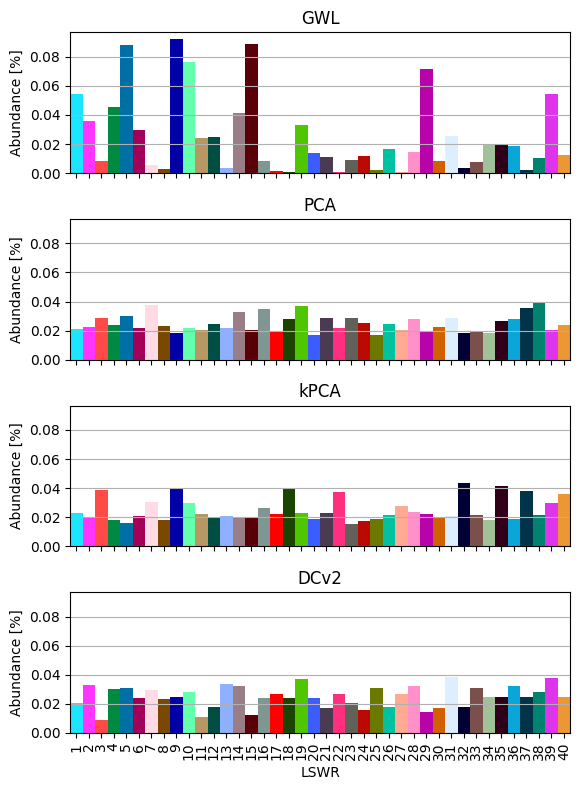

In [31]:
def plot_abundance(
    assignments: list[xr.DataArray],
) -> None:
    n_subplots = len(assignments)
    labels = np.arange(
        int(assignments[0].min()), int(assignments[0].max()) + 1, 1, dtype=int
    )
    x_lims = labels.min() - 0.5, labels.max() + 0.5
    bins = np.arange(x_lims[0], x_lims[1] + 1.0, 1.0)
    colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6, 2 * n_subplots),
        nrows=n_subplots,
        ncols=1,
        sharex=True,
        sharey=True,
    )

    plt.title(f"Abundance of LSWRs")

    for i, element in enumerate(assignments):
        _, _, patches = axs[i].hist(element, bins=bins, density=True)

        axs[i].set_title(element.name)

        if i == n_subplots - 1:
            axs[i].set_xlabel("LSWR")

        axs[i].set_ylabel("Abundance [%]")
        axs[i].set_xlim(*x_lims)
        axs[i].set_xticks(labels)
        axs[i].set_xticklabels(labels, rotation=90)
        axs[i].yaxis.grid(True)

        # ax2 = axs[i].twinx()
        # _, _, patches = ax2.hist(element, bins=bins, density=True)
        # ax2.set_ylabel("Relative [%]")

        if len(colors) != len(patches):
            raise RuntimeError(
                "Length of colors does not match number of patches in histogram"
            )

        for color, patch in zip(colors, patches):
            patch.set_facecolor(color)

    fig.tight_layout()
    plt.savefig(plots / "lswrs-abundance-comparison.pdf")


plot_abundance(lswrs)

In [ ]:
%%time

import seaborn as sns
import itertools


def plot_transition_matrix_heatmap(
    assignments: list[xr.DataArray],
) -> None:
    n_subplots = len(assignments)
    width_ratios = [1 for _ in enumerate(assignments)] + [0.08]

    # Add 1 subplot just for the colorbar
    fig, axs = plt.subplots(
        figsize=(6 * n_subplots, 6),
        nrows=1,
        ncols=n_subplots + 1,
        gridspec_kw={"width_ratios": width_ratios},
    )

    # Last element of axs is the cbar
    for ax1, ax2 in itertools.pairwise(axs[:-1]):
        ax1.sharey(ax2)

    axs_cbar = axs[-1]
    transitions = np.array(
        [
            a6.plotting.transitions._calculate_markov_transition_matrix(a)
            for a in assignments
        ]
    )
    max_prob = transitions.max()
    min_prob = transitions.min()

    for i, element in enumerate(assignments):
        transition = transitions[i]
        kwargs = (
            {"cbar": False}
            if i < n_subplots - 1
            else {"cbar_ax": axs_cbar, "cbar_kws": {"label": "probability"}}
        )
        sns.heatmap(
            transition,
            ax=axs[i],
            cmap="Reds",
            vmin=min_prob,
            vmax=max_prob,
            **kwargs
        )
        axs[i].set_title(element.name)
    fig.tight_layout()
    plt.savefig(plots / "lswrs-transition-probabilities-comparison.pdf")


plot_transition_matrix_heatmap(lswrs)

GWL
PCA
kPCA
DCv2


RANK None (LOCAL None) - DEBUG - 2024-05-08 18:02:43 - 2:54:11 - Assigning font /F1 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
RANK None (LOCAL None) - DEBUG - 2024-05-08 18:02:43 - 2:54:11 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
RANK None (LOCAL None) - DEBUG - 2024-05-08 18:02:43 - 2:54:11 - Writing TrueType font.


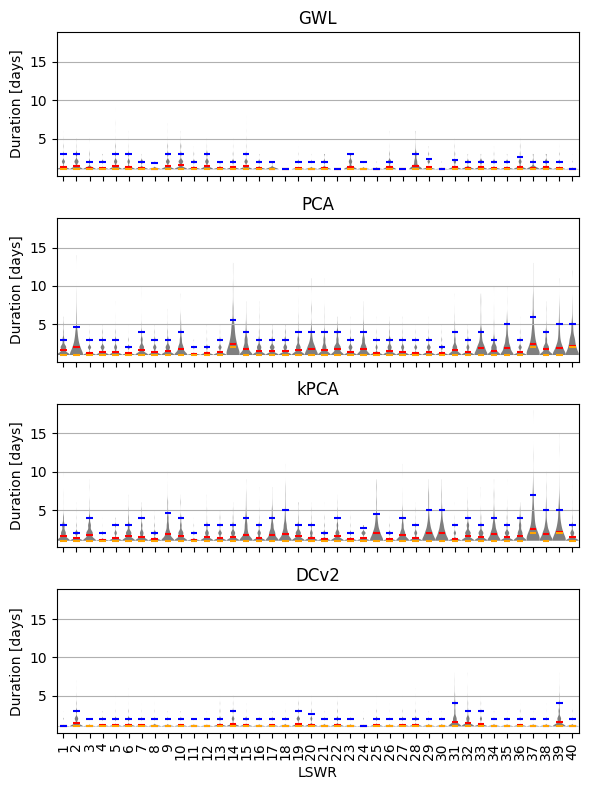

In [76]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
def convert(x):
        return x.total_seconds() / 60 / 60 / 24
def plot_modes_durations(
    assignments: list[xr.DataArray],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the mode mean durations and standard deviation."""
    n_subplots = len(assignments)
    modes = [
        a6.modes.methods.determine_lifetimes_of_modes(a) for a in assignments
    ]
    labels = np.arange(1, modes[0].size + 1, 1, dtype=int)

    x_lims = labels.min() - 0.5, labels.max() + 0.5
    colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6, 2 * n_subplots),
        nrows=n_subplots,
        ncols=1,
        sharex=True,
        sharey=True,
    )

    for i, element in enumerate(modes):
        name = assignments[i].name
        print(name)
        # (
        #     durations,
        #     stds,
        # ) = a6.plotting.modes.statistics._calculate_mean_durations_and_standard_deviations(
        #     element
        # )
        # axs[i].bar(
        #     labels,
        #     durations,
        #     yerr=stds,
        #     width=1.0,  # removes gaps between the bars
        #     color=colors,
        #     align="center",
        #     alpha=1,
        #     ecolor="black",
        #     capsize=3,
        # )
        
        durations = [[appearance.duration.days for appearance in e.appearances] for e in element]
        # parts = axs[i].boxplot(
        #     durations,
        #     showmeans=True,
        #     showfliers=False,
        #     showcaps=False,
        # ) 
        parts = axs[i].violinplot(
            durations,
            widths=1,
            showmeans=True,
            showmedians=True,
            showextrema=False,
            quantiles=[[.95] for _ in enumerate(durations)],
        )

        parts["cmeans"].set_color("red")
        parts["cmedians"].set_color("orange")
        # parts["cmins"].set_alpha(0.0)
        parts["cquantiles"].set_color("blue")
            
        for color, pc in zip(colors, parts['bodies']):
            pc.set_facecolor("black")
            # pc.set_edgecolor(color)
            pc.set_alpha(0.5)
        
        axs[i].set_title(name)

        if i == n_subplots - 1:
            axs[i].set_xlabel("LSWR")

        axs[i].set_ylabel("Duration [days]")
        axs[i].set_xlim(*x_lims)
        axs[i].set_xticks(labels)
        axs[i].set_xticklabels(labels, rotation=90)
        axs[i].yaxis.grid(True)

    fig.tight_layout()
    plt.savefig(plots / "lswrs-durations-comparison.pdf")


plot_modes_durations(lswrs)

In [ ]:
%%time


def calculate_mean_and_std(data: xr.Dataset, assignments: xr.DataArray):
    subset = (
        a6.datasets.methods.select.select_levels(levels=500)
        >> a6.features.methods.geopotential.calculate_geopotential_height()
    ).apply_to(data)

    modes = a6.modes.methods.determine_lifetimes_of_modes(assignments)
    dates = [list(mode.get_dates()) for mode in modes]
    z_h_per_mode = [
        subset["z_h"].sel(time=date, method="nearest") for date in dates
    ]

    means = [z_h.mean("time") for z_h in z_h_per_mode]
    means_max = max(mean.max() for mean in means)
    means_min = min(mean.min() for mean in means)

    stds = [z_h.std("time") for z_h in z_h_per_mode]
    stds_max = max(std.max() for std in stds)
    stds_min = min(std.min() for std in stds)

    return (
        assignments.name,
        modes,
        means,
        means_min,
        means_max,
        stds,
        stds_min,
        stds_max,
    )


means_stds = [
    calculate_mean_and_std(data=ds, assignments=assignments)
    for assignments in lswrs
]

In [ ]:
%%time
import cartopy.crs as ccrs


def round_to_decade(value: xr.DataArray) -> int:
    return int(np.round(value.values, -1))


def plot_geopotential_mean_and_std(
    name: str,
    modes,
    means: list[xr.DataArray],
    means_min: float,
    means_max: float,
    stds: list[xr.DataArray],
    stds_min: float,
    stds_max: float,
) -> tuple[plt.Figure, plt.Axes]:
    """Plot geopotential height contours, temperature and wind speed."""
    labels = np.arange(1, modes.size + 1, 1, dtype=int)

    n_rows = 8
    n_cols = 5

    if n_rows * n_cols != labels.max():
        raise ValueError("Number of plots not equal to number of LSWRs")

    height = n_rows * 2
    width = n_cols * 2.5

    fig, axs = plt.subplots(
        figsize=(width, height),
        nrows=n_rows,
        # Add 2 columns for colorbars
        # ncols=n_cols + 2,
        ncols=n_cols,
        subplot_kw=a6.plotting.coastlines.create_projection(),
        # gridspec_kw={"width_ratios": [1 for _ in range(n_cols)] + [0.05, 0.05]},
    )
    levels = list(
        range(
            round_to_decade(means_min),
            round_to_decade(means_max),
            5,
        )
    )

    for i, ax in enumerate(axs.flatten()):
        z_h_mean = means[i]
        z_h_std = stds[i]
        heatmap = z_h_std.plot(
            ax=ax,
            cmap="RdBu",
            vmin=stds_min,
            vmax=stds_max,
            add_colorbar=False,
        )

        contours = z_h_mean.plot.contour(
            ax=ax,
            levels=levels,
            cmap="cool",
            transform=ccrs.PlateCarree(),
            linewidths=1.0,
        )
        # contours.clabel(inline=True)
        #         handles_unfilled, labels = cs_unfilled.legend_elements()

        #         ax.legend(handles_filled + handles_unfilled,
        #                   ["range(2-3)", "range(3-4)", "range(4-6)", "3", "4", "6"],
        #                   ncols=2)
        ax.coastlines(alpha=0.5)
        # ax.gridlines(draw_labels=["left", "bottom"])
        ax.set_title(f"{i + 1}")
    fig.suptitle(name)
    # fig.colorbar(heatmap, ax=axs[:,-2], label=r"$\mu(z_\mathrm{500})$ [m]")
    fig.tight_layout()
    plt.savefig(plots / f"lswrs-geopotential-heights-{name}.pdf")


for mean_std in means_stds:
    plot_geopotential_mean_and_std(*mean_std)

## Clean production data for plotting

In [5]:
%%time

"""
NOTE: Preprocess turbine data. This takes ~22 min, so prefer loading (cell below)
if no changes to the preprocessing are required.
"""

paths = list(
    pathlib.Path("/p/home/jusers/emmerich1/juwels/data/production").glob(
        "**/*.nc"
    )
)
print(paths)


def remove_outliers(data: xr.Dataset) -> xr.Dataset:
    power_rating = float(data.attrs["power rating"].split()[0])
    print(power_rating)
    # Only use data points where
    # - production is lower than power rating
    # - production is greater than 0
    return a6.datasets.methods.turbine.clean_production_data(
        power_rating=power_rating,
    ).apply_to(data)


# Contains the turbine name and the production
turbines: dict[str, xr.Dataset] = {
    path.name: remove_outliers(xr.open_dataset(path)) for path in paths
}

# NOTE: Uncomment to save preprocessed data to disk.

for name, data in turbines.items():
    data.to_netcdf(
        f"/p/home/jusers/emmerich1/juwels/data/production-cleaned-for-analysis/{name}.nc"
    )

RANK None (LOCAL None) - DEBUG - 2024-04-17 16:39:00 - 0:01:58 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3300.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:39:00 - 0:01:58 - Memory consumption of function 'clean_production_data': before: 828,321,792, after: 828,321,792, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:39:00 - 0:01:58 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3300.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:39:00 - 0:01:58 - 'status' in production data, removing data where status is 0.0


[PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v211315.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v219952.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/VE229459.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v217754.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v220747.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v43796.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v219948.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v20508.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v220745.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v217755.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v43798.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/v221797.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/production/EN441836.nc'), PosixPath('/p/home/jusers/emmerich1/juwels/data/pro

RANK None (LOCAL None) - INFO - 2024-04-17 16:39:37 - 0:02:35 - Removed 44342 samples (18.65%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:39:37 - 0:02:35 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:39:37 - 0:02:35 - Memory consumption of function 'clean_production_data': before: 902,844,416, after: 902,844,416, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:39:37 - 0:02:35 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:39:37 - 0:02:35 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:40:05 - 0:03:03 - Removed 36136 samples (19.71%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:05 - 0:03:03 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 4200.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:05 - 0:03:03 - Memory consumption of function 'clean_production_data': before: 903,049,216, after: 903,049,216, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:05 - 0:03:03 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 4200.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:40:05 - 0:03:03 - 'status' in production data, removing data where status is 0.0


4200.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:40:19 - 0:03:17 - Removed 19769 samples (21.17%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:19 - 0:03:17 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:19 - 0:03:17 - Memory consumption of function 'clean_production_data': before: 903,049,216, after: 903,049,216, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:19 - 0:03:17 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:40:19 - 0:03:17 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:40:49 - 0:03:47 - Removed 41156 samples (20.13%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:49 - 0:03:47 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:49 - 0:03:47 - Memory consumption of function 'clean_production_data': before: 945,229,824, after: 945,229,824, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:40:49 - 0:03:47 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:40:49 - 0:03:47 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:41:16 - 0:04:14 - Removed 35183 samples (19.97%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:41:16 - 0:04:14 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:41:16 - 0:04:14 - Memory consumption of function 'clean_production_data': before: 948,797,440, after: 948,797,440, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:41:16 - 0:04:14 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:41:16 - 0:04:14 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:41:50 - 0:04:49 - Removed 50885 samples (21.50%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:41:50 - 0:04:49 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:41:50 - 0:04:49 - Memory consumption of function 'clean_production_data': before: 1,008,234,496, after: 1,008,234,496, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:41:50 - 0:04:49 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:41:50 - 0:04:49 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:42:16 - 0:05:14 - Removed 40298 samples (23.27%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:42:16 - 0:05:14 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:42:16 - 0:05:14 - Memory consumption of function 'clean_production_data': before: 1,008,234,496, after: 1,008,234,496, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:42:16 - 0:05:14 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:42:16 - 0:05:14 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:42:49 - 0:05:47 - Removed 53637 samples (23.23%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:42:49 - 0:05:47 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:42:49 - 0:05:47 - Memory consumption of function 'clean_production_data': before: 1,036,767,232, after: 1,036,767,232, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:42:49 - 0:05:47 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:42:49 - 0:05:47 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:43:15 - 0:06:14 - Removed 29574 samples (17.13%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:43:15 - 0:06:14 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:43:15 - 0:06:14 - Memory consumption of function 'clean_production_data': before: 1,036,771,328, after: 1,036,771,328, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:43:15 - 0:06:14 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:43:15 - 0:06:14 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:43:46 - 0:06:44 - Removed 39778 samples (19.51%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:43:46 - 0:06:44 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:43:46 - 0:06:44 - Memory consumption of function 'clean_production_data': before: 1,070,956,544, after: 1,070,956,544, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:43:46 - 0:06:44 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:43:46 - 0:06:44 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:44:23 - 0:07:22 - Removed 36101 samples (15.31%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:23 - 0:07:22 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:23 - 0:07:22 - Memory consumption of function 'clean_production_data': before: 1,132,871,680, after: 1,132,871,680, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:23 - 0:07:22 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:44:23 - 0:07:22 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:44:49 - 0:07:48 - Removed 30950 samples (18.13%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:49 - 0:07:48 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 600.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:49 - 0:07:48 - Memory consumption of function 'clean_production_data': before: 1,132,871,680, after: 1,132,871,680, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:49 - 0:07:48 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 600.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:44:49 - 0:07:48 - 'status' in production data, removing data where status is 0.0


600.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:44:53 - 0:07:52 - Removed 3567 samples (14.84%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:53 - 0:07:52 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:53 - 0:07:52 - Memory consumption of function 'clean_production_data': before: 1,132,871,680, after: 1,132,871,680, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:44:53 - 0:07:52 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:44:53 - 0:07:52 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:45:19 - 0:08:17 - Removed 37929 samples (21.87%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:45:19 - 0:08:17 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:45:19 - 0:08:17 - Memory consumption of function 'clean_production_data': before: 1,132,871,680, after: 1,132,871,680, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:45:19 - 0:08:17 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:45:19 - 0:08:17 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:45:52 - 0:08:50 - Removed 58836 samples (25.12%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:45:52 - 0:08:50 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:45:52 - 0:08:50 - Memory consumption of function 'clean_production_data': before: 1,147,604,992, after: 1,147,604,992, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:45:52 - 0:08:50 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:45:52 - 0:08:50 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:46:20 - 0:09:19 - Removed 37958 samples (20.60%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:20 - 0:09:19 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 5600.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:20 - 0:09:19 - Memory consumption of function 'clean_production_data': before: 1,148,096,512, after: 1,148,096,512, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:20 - 0:09:19 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 5600.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:46:20 - 0:09:19 - 'status' in production data, removing data where status is 0.0


5600.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:46:23 - 0:09:21 - Removed 7829 samples (41.08%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:23 - 0:09:21 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:23 - 0:09:21 - Memory consumption of function 'clean_production_data': before: 1,148,096,512, after: 1,148,096,512, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:23 - 0:09:21 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:46:23 - 0:09:21 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:46:49 - 0:09:48 - Removed 31463 samples (17.97%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:49 - 0:09:48 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:49 - 0:09:48 - Memory consumption of function 'clean_production_data': before: 1,160,368,128, after: 1,160,368,128, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:46:49 - 0:09:48 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:46:49 - 0:09:48 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:47:17 - 0:10:15 - Removed 24758 samples (14.60%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:47:17 - 0:10:15 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:47:17 - 0:10:15 - Memory consumption of function 'clean_production_data': before: 1,181,372,416, after: 1,181,372,416, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:47:17 - 0:10:15 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:47:17 - 0:10:15 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:47:51 - 0:10:49 - Removed 48849 samples (21.46%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:47:51 - 0:10:49 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2050.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:47:51 - 0:10:49 - Memory consumption of function 'clean_production_data': before: 1,239,072,768, after: 1,239,072,768, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:47:51 - 0:10:49 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2050.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:47:51 - 0:10:49 - 'status' in production data, removing data where status is 0.0


2050.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:48:31 - 0:11:30 - Removed 19854 samples (8.49%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:48:31 - 0:11:30 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 600.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:48:31 - 0:11:30 - Memory consumption of function 'clean_production_data': before: 1,290,326,016, after: 1,290,326,016, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:48:31 - 0:11:30 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 600.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:48:31 - 0:11:30 - 'status' in production data, removing data where status is 0.0


600.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:48:35 - 0:11:34 - Removed 3400 samples (14.15%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:48:35 - 0:11:34 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:48:35 - 0:11:34 - Memory consumption of function 'clean_production_data': before: 1,290,326,016, after: 1,290,326,016, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:48:35 - 0:11:34 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:48:35 - 0:11:34 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:49:02 - 0:12:01 - Removed 27893 samples (16.08%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:49:02 - 0:12:01 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:49:02 - 0:12:01 - Memory consumption of function 'clean_production_data': before: 1,290,326,016, after: 1,290,326,016, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:49:02 - 0:12:01 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:49:02 - 0:12:01 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:49:30 - 0:12:28 - Removed 35360 samples (19.25%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:49:30 - 0:12:28 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:49:30 - 0:12:28 - Memory consumption of function 'clean_production_data': before: 1,290,326,016, after: 1,290,326,016, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:49:30 - 0:12:28 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:49:30 - 0:12:28 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:50:02 - 0:13:00 - Removed 51938 samples (22.94%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:02 - 0:13:01 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:02 - 0:13:01 - Memory consumption of function 'clean_production_data': before: 1,317,023,744, after: 1,317,023,744, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:02 - 0:13:01 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:50:02 - 0:13:01 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:50:29 - 0:13:27 - Removed 37295 samples (20.84%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:29 - 0:13:27 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 4200.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:29 - 0:13:27 - Memory consumption of function 'clean_production_data': before: 1,317,023,744, after: 1,317,023,744, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:29 - 0:13:27 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 4200.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:50:29 - 0:13:27 - 'status' in production data, removing data where status is 0.0


4200.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:50:43 - 0:13:41 - Removed 17948 samples (18.77%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:43 - 0:13:41 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:43 - 0:13:41 - Memory consumption of function 'clean_production_data': before: 1,317,023,744, after: 1,317,023,744, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:50:43 - 0:13:41 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:50:43 - 0:13:41 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:51:09 - 0:14:07 - Removed 34661 samples (19.99%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:09 - 0:14:07 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 600.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:09 - 0:14:07 - Memory consumption of function 'clean_production_data': before: 1,317,023,744, after: 1,317,023,744, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:09 - 0:14:07 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 600.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:51:09 - 0:14:07 - 'status' in production data, removing data where status is 0.0


600.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:51:12 - 0:14:11 - Removed 3369 samples (14.02%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:12 - 0:14:11 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:12 - 0:14:11 - Memory consumption of function 'clean_production_data': before: 1,317,023,744, after: 1,317,023,744, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:12 - 0:14:11 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:51:12 - 0:14:11 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:51:39 - 0:14:37 - Removed 27498 samples (16.39%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:39 - 0:14:37 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3600.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:39 - 0:14:37 - Memory consumption of function 'clean_production_data': before: 1,335,779,328, after: 1,335,779,328, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:39 - 0:14:37 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3600.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:51:39 - 0:14:37 - 'status' in production data, removing data where status is 0.0


3600.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:51:40 - 0:14:38 - Removed 14099 samples (68.49%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:40 - 0:14:38 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:40 - 0:14:38 - Memory consumption of function 'clean_production_data': before: 1,335,783,424, after: 1,335,783,424, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:51:40 - 0:14:38 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:51:40 - 0:14:38 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:52:13 - 0:15:12 - Removed 49951 samples (21.90%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:52:13 - 0:15:12 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:52:13 - 0:15:12 - Memory consumption of function 'clean_production_data': before: 1,394,532,352, after: 1,394,532,352, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:52:13 - 0:15:12 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:52:13 - 0:15:12 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:52:35 - 0:15:33 - Removed 21592 samples (15.98%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:52:35 - 0:15:33 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:52:35 - 0:15:33 - Memory consumption of function 'clean_production_data': before: 1,394,991,104, after: 1,394,991,104, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:52:35 - 0:15:33 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:52:35 - 0:15:33 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:53:09 - 0:16:07 - Removed 45616 samples (19.96%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:53:09 - 0:16:07 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:53:09 - 0:16:07 - Memory consumption of function 'clean_production_data': before: 1,433,739,264, after: 1,433,739,264, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:53:09 - 0:16:07 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:53:09 - 0:16:07 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:53:36 - 0:16:34 - Removed 31695 samples (18.18%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:53:36 - 0:16:34 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:53:36 - 0:16:34 - Memory consumption of function 'clean_production_data': before: 1,433,747,456, after: 1,433,747,456, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:53:36 - 0:16:34 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:53:36 - 0:16:34 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:54:14 - 0:17:12 - Removed 37073 samples (15.66%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:54:14 - 0:17:12 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 2000.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:54:14 - 0:17:12 - Memory consumption of function 'clean_production_data': before: 1,487,564,800, after: 1,487,564,800, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:54:14 - 0:17:12 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 2000.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:54:14 - 0:17:12 - 'status' in production data, removing data where status is 0.0


2000.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:54:49 - 0:17:48 - Removed 45351 samples (19.35%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:54:49 - 0:17:48 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:54:49 - 0:17:48 - Memory consumption of function 'clean_production_data': before: 1,507,201,024, after: 1,507,201,024, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:54:49 - 0:17:48 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:54:49 - 0:17:48 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:55:14 - 0:18:13 - Removed 37757 samples (22.10%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:14 - 0:18:13 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3600.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:14 - 0:18:13 - Memory consumption of function 'clean_production_data': before: 1,507,201,024, after: 1,507,201,024, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:14 - 0:18:13 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3600.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:55:14 - 0:18:13 - 'status' in production data, removing data where status is 0.0


3600.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:55:27 - 0:18:26 - Removed 25559 samples (26.77%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:27 - 0:18:26 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:27 - 0:18:26 - Memory consumption of function 'clean_production_data': before: 1,507,201,024, after: 1,507,201,024, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:27 - 0:18:26 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:55:27 - 0:18:26 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:55:54 - 0:18:52 - Removed 44312 samples (24.14%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:54 - 0:18:52 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3300.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:54 - 0:18:52 - Memory consumption of function 'clean_production_data': before: 1,507,201,024, after: 1,507,201,024, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:55:54 - 0:18:52 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3300.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:55:54 - 0:18:52 - 'status' in production data, removing data where status is 0.0


3300.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:56:25 - 0:19:23 - Removed 35645 samples (17.53%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:56:25 - 0:19:24 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:56:25 - 0:19:24 - Memory consumption of function 'clean_production_data': before: 1,532,379,136, after: 1,532,379,136, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:56:25 - 0:19:24 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:56:25 - 0:19:24 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:56:51 - 0:19:49 - Removed 35040 samples (20.21%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:56:51 - 0:19:50 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:56:51 - 0:19:50 - Memory consumption of function 'clean_production_data': before: 1,532,391,424, after: 1,532,391,424, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:56:51 - 0:19:50 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:56:51 - 0:19:50 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:57:17 - 0:20:15 - Removed 34637 samples (20.13%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:57:17 - 0:20:15 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 850.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:57:17 - 0:20:15 - Memory consumption of function 'clean_production_data': before: 1,545,633,792, after: 1,545,633,792, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:57:17 - 0:20:15 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 850.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:57:17 - 0:20:15 - 'status' in production data, removing data where status is 0.0


850.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:57:50 - 0:20:49 - Removed 58877 samples (25.10%)
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:57:50 - 0:20:49 - Calling function 'clean_production_data' with args: () and kwargs: {'power_rating': 3450.0}
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:57:50 - 0:20:49 - Memory consumption of function 'clean_production_data': before: 1,601,306,624, after: 1,601,306,624, consumed: 0, exec time: 00:00:00
RANK None (LOCAL None) - DEBUG - 2024-04-17 16:57:50 - 0:20:49 - Cleaning production data (variables Turbine(production='production', power_rating='power rating', name='wind plant')) with power rating 3450.0
RANK None (LOCAL None) - INFO - 2024-04-17 16:57:50 - 0:20:49 - 'status' in production data, removing data where status is 0.0


3450.0


RANK None (LOCAL None) - INFO - 2024-04-17 16:58:17 - 0:21:15 - Removed 35095 samples (19.88%)


CPU times: user 19min 11s, sys: 3.73 s, total: 19min 15s
Wall time: 19min 20s


In [6]:
# Open preprocessed turbine data if available
paths = list(
    pathlib.Path(
        "/p/home/jusers/emmerich1/juwels/data/production-cleaned-for-analysis"
    ).glob("**/*.nc")
)
# Contains the turbine name and the production
turbines: dict[str, xr.Dataset] = {
    path.name: xr.open_dataset(path) for path in paths
}

## Relation of LSWRs to Power Production

In [13]:
%%time

import dataclasses
import datetime


@dataclasses.dataclass
class PowerPerMode:
    label: int
    measurements: list[int] = dataclasses.field(default_factory=list)
    sum: list[float] = dataclasses.field(default_factory=list)
    mean: list[float] = dataclasses.field(default_factory=list)
    std: list[float] = dataclasses.field(default_factory=list)
    normalized_mean: list[float] = dataclasses.field(default_factory=list)
    normalized_std: list[float] = dataclasses.field(default_factory=list)


def get_power_per_lswr(data: xr.Dataset) -> dict[int, PowerPerMode]:
    modes = a6.modes.methods.determine_lifetimes_of_modes(data)
    dates = [xr.DataArray(list(mode.get_dates())) for mode in modes]

    power_per_mode = {
        mode.label: PowerPerMode(label=mode.label) for mode in modes
    }

    for i, (name, turbine) in enumerate(turbines.items()):
        print(f"{data.name}: {i}/{len(turbines)}", end="\r")
        power_rating = float(turbine.attrs["power rating"].split()[0])

        # Resample to daily production and calculate sum, relative mean and std
        resampled = turbine["production"].resample({"time": "1d"}, skipna=True)
        daily_sum = resampled.sum(skipna=True)
        daily_mean = resampled.mean(skipna=True)
        daily_mean_normalized = daily_mean / power_rating
        daily_std = resampled.std(skipna=True)
        daily_std_normalized = daily_std / power_rating

        for mode, date in zip(modes, dates, strict=True):
            mode_power = power_per_mode[mode.label]

            # Get time steps of production where LSWR appeared
            intersection = sorted(set(daily_sum.time.values) & set(date.values))

            # if not intersection:
            #     print(f"WARNING: empty intersection for {name} and mode {mode.label}")
            #     continue

            # Count number of days that contribute to the results
            mode_power.measurements.append(len(intersection))

            # Select time steps of LSWR appearance and calculate sum
            total = daily_sum.sel(time=intersection)
            mode_power.sum.extend(total.values.flatten().tolist())

            # Select time steps of LSWR appearance and calculate mean
            mean = daily_mean.sel(time=intersection)
            mean_normalized = daily_mean_normalized.sel(time=intersection)
            mode_power.mean.extend(mean.values.flatten().tolist())
            mode_power.normalized_mean.extend(
                mean_normalized.values.flatten().tolist()
            )

            # Select time steps of LSWR appearance and calculate std
            std = daily_std.sel(time=intersection)
            std_normalized = daily_std_normalized.sel(time=intersection)
            mode_power.std.extend(std.values.flatten().tolist())
            mode_power.normalized_std.extend(
                std_normalized.values.flatten().tolist()
            )
    return power_per_mode


power_per_method = {lswr.name: get_power_per_lswr(lswr) for lswr in lswrs}

CPU times: user 4min 47s, sys: 11.9 s, total: 4min 59s
Wall time: 5min 1s


In [ ]:
import pandas as pd

latex_code = []


def power_mean_with_std_as_string(stats: list[float]) -> str:
    return f"${np.nanmean(stats) * 100:.2f} \pm {np.nanstd(stats) * 100:.2f}$"


columns = {
    "$N$": lambda lswrs: [
        np.nansum(results.measurements) for results in lswrs.values()
    ],
    "$P_{\mathrm{total}}$ [kW]": lambda lswrs: [
        f"{int(np.nansum(results.sum)):d}" for results in lswrs.values()
    ],
    "$P^{\mathrm{mean}}_{\mathrm{normalized}}$ [\%]": lambda lswrs: [
        power_mean_with_std_as_string(results.normalized_mean)
        for results in lswrs.values()
    ],
    "$P^{\mathrm{std}}_{\mathrm{normalized}}$ [\%]": lambda lswrs: [
        power_mean_with_std_as_string(results.normalized_std)
        for results in lswrs.values()
    ],
}

reform = {
    (name, column): func(method)
    for name, method in power_per_method.items()
    for column, func in columns.items()
}

df = pd.DataFrame.from_dict(reform)

# Add 1 to start indexing at 1 to be conform with LSWR labels
df.index += 1

code = df.to_latex(
    float_format="%.2f",
    label="production-per-lswr-per-method",
    caption=f"Power production for the resulting LSWRs.",
)


with open(
    "/p/home/jusers/emmerich1/juwels/code/a6/notebooks/power-production-table.tex",
    "w",
) as f:
    f.write(code)

df

/tmp/ipykernel_15630/1464827845.py:27: RuntimeWarning: Mean of empty slice
  np.nanmean(power.normalized_mean) * 100
/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
RANK None (LOCAL None) - DEBUG - 2024-04-17 17:48:01 - 1:11:00 - Assigning font /F1 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
RANK None (LOCAL None) - DEBUG - 2024-04-17 17:48:01 - 1:11:00 - Assigning font /F2 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
RANK None (LOCAL None) - DEBUG - 2024-04-17 17:48:02 - 1:11:00 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
RANK None (LOCAL None) - DEBUG - 2024-04-17 17:48:02 - 1:11:00 - Writing TrueType font.
RANK None (LOCAL None) - DEBUG - 2024-04-17 17:48:02 - 1:11:00 - Embedding font /venv/lib/python3.11/s

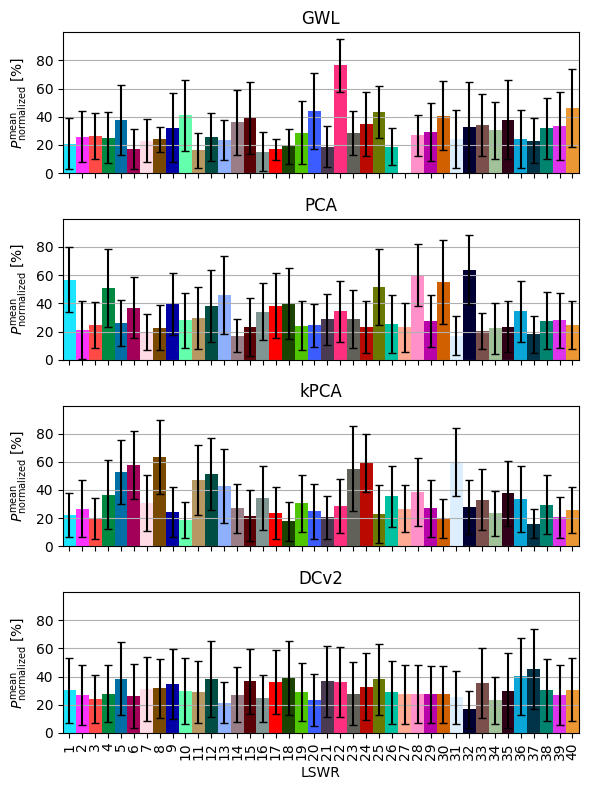

In [15]:
import matplotlib.pyplot as plt


def plot_power_per_mode(
    powers: dict[str, dict[int, PowerPerMode]],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the power production for each LSWR and method."""
    n_rows = len(powers)
    n_cols = 1
    labels = np.arange(1, n_lswr_categories + 1, dtype=int)

    x_lims = labels.min() - 0.5, labels.max() + 0.5
    colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6 * n_cols, 2 * n_rows),
        nrows=n_rows,
        ncols=n_cols,
        sharex=True,
        sharey=True,
    )

    plt.title(f"Power production per LSWRs")

    for i, (method, powers_per_lswr) in enumerate(powers.items()):
        powers_means = [
            np.nanmean(power.normalized_mean) * 100
            for power in powers_per_lswr.values()
        ]
        powers_stds = [
            np.nanstd(power.normalized_mean) * 100
            for power in powers_per_lswr.values()
        ]
        ax = axs[i]

        ax.bar(
            labels,
            powers_means,
            yerr=powers_stds,
            width=1.0,  # removes gaps between the bars
            color=colors,
            align="center",
            alpha=1,
            ecolor="black",
            capsize=3,
        )
        parts = axs[i].violinplot(
            durations,
            widths=1,
            showmeans=True,
            showmedians=True,
            showextrema=False,
            quantiles=[[.95] for _ in enumerate(durations)],
        )

        parts["cmeans"].set_color("red")
        parts["cmedians"].set_color("orange")
        # parts["cmins"].set_alpha(0.0)
        parts["cquantiles"].set_color("blue")
            
        for color, pc in zip(colors, parts['bodies']):
            pc.set_facecolor("black")
            # pc.set_edgecolor(color)
            pc.set_alpha(0.5)

        ax.set_title(method)

        if i == n_rows - 1:
            ax.set_xlabel("LSWR")

        ax.set_ylabel(r"$P^{\mathrm{mean}}_{\mathrm{normalized}}$ [%]")
        ax.set_xlim(*x_lims)
        ax.set_xticks(labels)
        ax.set_xticklabels(labels, rotation=90)
        ax.yaxis.grid(True)

    fig.tight_layout()
    plt.savefig(plots / "lswrs-power-production-comparison.pdf")


plot_power_per_mode(power_per_method)

RANK None (LOCAL None) - DEBUG - 2024-05-08 15:41:49 - 0:33:17 - Assigning font /F1 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
RANK None (LOCAL None) - DEBUG - 2024-05-08 15:41:49 - 0:33:17 - Assigning font /F2 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
RANK None (LOCAL None) - DEBUG - 2024-05-08 15:41:49 - 0:33:17 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
RANK None (LOCAL None) - DEBUG - 2024-05-08 15:41:49 - 0:33:17 - Writing TrueType font.
RANK None (LOCAL None) - DEBUG - 2024-05-08 15:41:49 - 0:33:17 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
RANK None (LOCAL None) - DEBUG - 2024-05-08 15:41:49 - 0:33:17 - Writing TrueType font.


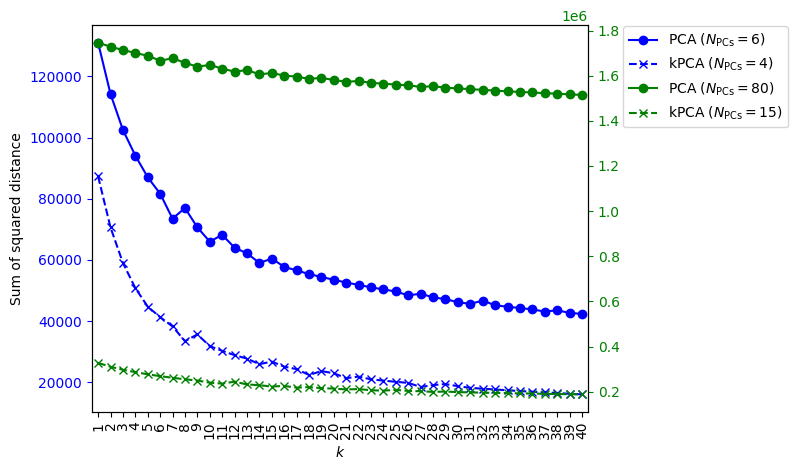

In [24]:
sses = joblib.load(plots / "../data/scree-test-results.dict")
sse_pca_1, sse_kpca_1 = sses["sses_pca_6_kpca_4"]
sse_pca_2, sse_kpca_2  = sses["sses_pca_80_kpca_15"]

ax1_color = "blue"
ax2_color = "green"

ks = range(1, len(sse_pca_1) + 1)

fig, ax1 = plt.subplots()
ax1.plot(ks, sse_pca_1, linestyle="-", marker='o', color=ax1_color, label=r"PCA $(N_{\mathrm{PCs}} = 6)$")
ax1.plot(ks, sse_kpca_1, linestyle="--", marker='x', color=ax1_color, label="kPCA $(N_{\mathrm{PCs}} = 4)$")

ax2 = ax1.twinx()
ax2.plot(ks, sse_pca_2, linestyle="-", marker='o', color=ax2_color, label=r"PCA $(N_{\mathrm{PCs}} = 80)$")
ax2.plot(ks, sse_kpca_2, linestyle="--", marker='x', color=ax2_color, label="kPCA $(N_{\mathrm{PCs}} = 15)$")

ax1.set_xlabel(r'$k$')
ax1.set_xticks(ks)
ax1.set_xticklabels([str(k) for k in ks], rotation=90)
ax1.set_ylabel('Sum of squared distance')

for ax, color in [(ax1, ax1_color), (ax2, ax2_color)]:
    # Set log scale.
    #ax.set(yscale="log")
    # Set left xlim such that the first tick disappears.
    ax.set_xlim(0.5, max(ks) + 0.5)
    # Color the ticks.
    ax.tick_params(axis="y", colors=color, which="both")

fig.legend(bbox_to_anchor=(1.25, 0.95))

fig.tight_layout()
plt.savefig(plots / "kmeans-scree-test.pdf")